# TITANIC PREDICTION - Random forest

## Information

This is a NOTEBOOK about the Titanic ML competition on Kaggle. [more info here](https://www.kaggle.com/competitions/titanic/overview)

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.


The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.



## Load

In [173]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [174]:
filename = "./train.csv"
titanic_dataset = pd.read_csv(filename, delimiter=",")

In [175]:
titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dataset information

In [176]:
titanic_dataset.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [177]:
titanic_dataset.shape[0]

891

In [178]:
titanic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## EDA

### Analysis

In [179]:
print("---------- NULLS --------")
print(titanic_dataset.isnull().sum())

---------- NULLS --------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


To understand if these null fields are important, let's analyze the data regarding survival/non-survival.

In [180]:
age_null = titanic_dataset[titanic_dataset["Age"].isnull()]

age_null["Title"] = age_null["Name"].str.extract(r',\s*([^\.]+)\.')

survivors_null_age = age_null[age_null["Survived"] == 1]

print(survivors_null_age["Title"].value_counts())

survivors_null_children_female = survivors_null_age[survivors_null_age["Title"].isin(["Master", "Miss", "Mrs"])]
survivors_null_male = survivors_null_age[survivors_null_age["Title"].isin(["Mr"])]

not_survivors_null_age = age_null[age_null["Survived"] == 0]
not_survivors_null_children_female = not_survivors_null_age[not_survivors_null_age["Title"].isin(["Master", "Miss", "Mrs"])]
not_survivors_null_male = not_survivors_null_age[not_survivors_null_age["Title"].isin(["Mr"])]

print("---------------------")

print("surviving nulls:",age_null.shape[0])
print("surviving people:",survivors_null_age.shape[0])
print("surviving children and women:", survivors_null_children_female.shape[0])
print("surviving male:", survivors_null_male.shape[0])
print("surviving male with children: ",(survivors_null_age[survivors_null_age["Parch"] > 0]).shape[0])

print("not surviving people:", not_survivors_null_age.shape[0])
print("not surviving children and women:", not_survivors_null_children_female.shape[0])
print("not surviving male:", not_survivors_null_male.shape[0])

print("---------------------")

Title
Miss      22
Mr        14
Mrs       14
Master     2
Name: count, dtype: int64
---------------------
surviving nulls: 177
surviving people: 52
surviving children and women: 38
surviving male: 14
surviving male with children:  5
not surviving people: 125
not surviving children and women: 19
not surviving male: 105
---------------------


/tmp/ipython-input-2777551741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_null["Title"] = age_null["Name"].str.extract(r',\s*([^\.]+)\.')


We keep the titles of each passenger

In [181]:
titanic_dataset["Title"] = titanic_dataset["Name"].str.extract(r',\s*([^\.]+)\.')

In [182]:
title_mapping = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Mrs",
    "the Countess": "Mrs",
    "Doña": "Mrs",
    "Capt": "Mr",
    "Col": "Mr",
    "Don": "Mr",
    "Dr": "Mr",
    "Major": "Mr",
    "Rev": "Mr",
    "Sir": "Mr",
    "Jonkheer": "Mr"
}

titanic_dataset["Title"] = titanic_dataset["Title"].replace(title_mapping)

In [183]:
titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [184]:
dataset = titanic_dataset.drop(columns=["Age", "Cabin", "Name", "Ticket", "Embarked"])

In [185]:
cols_continuous = dataset.columns[dataset.dtypes!=object].tolist()
cols_text = ["Sex", "Title"]

def isBinary(column):
    return column.isin([0, 1]).all()

cols_categorical = 0
binary_columns = [col for col in dataset.columns if isBinary(dataset[col]) and dataset[col].dtype != object]
unique_counts = dataset.nunique()
categorical_columns = ["Pclass"] + cols_text;
cols_categorical = len(binary_columns) + len(categorical_columns)
columns_to_drop = set(binary_columns + categorical_columns)
df_continuous = dataset.drop(columns=list(columns_to_drop))
df_categorical = dataset.drop(columns=df_continuous.columns)

print("There are ",len(dataset.columns)," columns")
print("There are ",len(df_continuous.columns)," continuous columns")
print("There are ", cols_categorical," categorical columns")

There are  8  columns
There are  4  continuous columns
There are  4  categorical columns


In [186]:
print(df_categorical)

     Survived  Pclass     Sex Title
0           0       3    male    Mr
1           1       1  female   Mrs
2           1       3  female  Miss
3           1       1  female   Mrs
4           0       3    male    Mr
..        ...     ...     ...   ...
886         0       2    male    Mr
887         1       1  female  Miss
888         0       3  female  Miss
889         1       1    male    Mr
890         0       3    male    Mr

[891 rows x 4 columns]


In [187]:
print(df_continuous)

     PassengerId  SibSp  Parch     Fare
0              1      1      0   7.2500
1              2      1      0  71.2833
2              3      0      0   7.9250
3              4      1      0  53.1000
4              5      0      0   8.0500
..           ...    ...    ...      ...
886          887      0      0  13.0000
887          888      0      0  30.0000
888          889      1      2  23.4500
889          890      0      0  30.0000
890          891      0      0   7.7500

[891 rows x 4 columns]


### Histogram

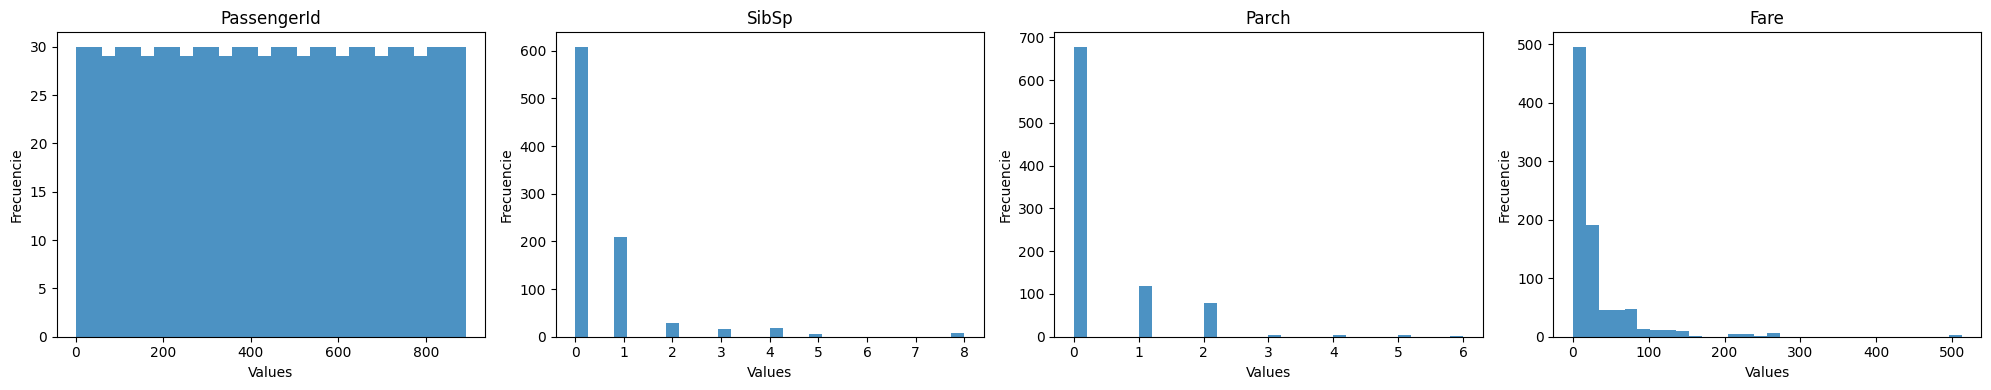

In [188]:
num_vars = df_continuous.shape[1]
num_cols = 5
num_rows = math.ceil(num_vars / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5*num_cols, 4*num_rows))

axes = axes.flatten()

for i, col in enumerate(df_continuous.columns):
    df_continuous[col].hist(ax=axes[i], bins=30, alpha=0.8)
    axes[i].set_title(col)
    axes[i].set_ylabel('Frecuencie')
    axes[i].set_xlabel('Values')
    axes[i].grid(False)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### boxplot

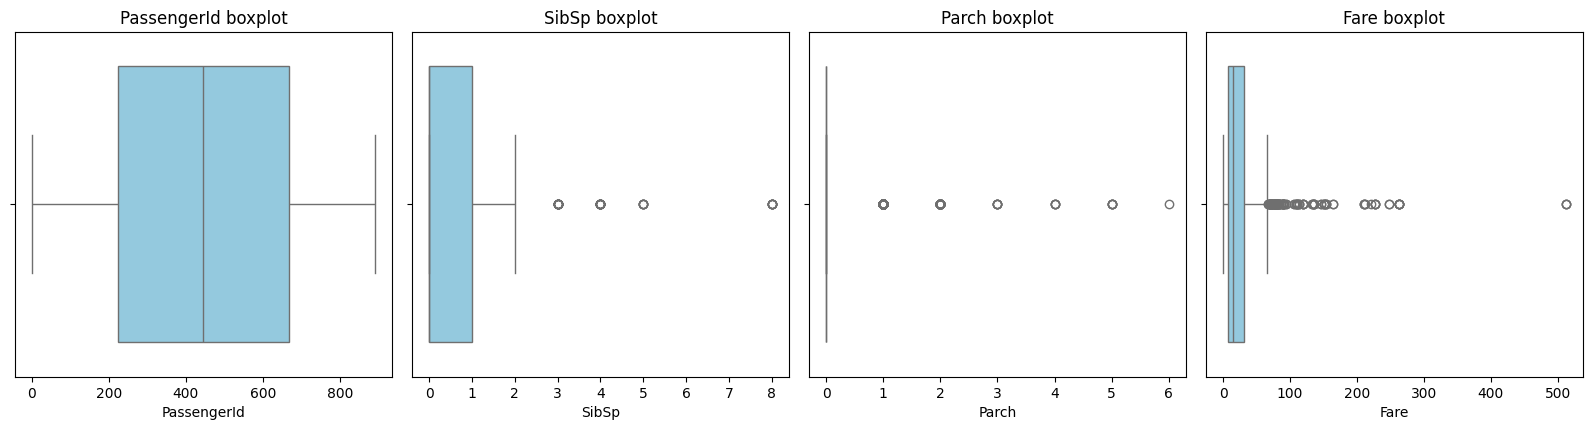

In [189]:
num_vars = df_continuous.shape[1]
num_cols = 5
num_rows = math.ceil(num_vars / num_cols)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for idx, item in enumerate(df_continuous.keys()):
    if idx < len(axes):
        sb.boxplot(x=df_continuous[item], ax=axes[idx], color='skyblue')
        axes[idx].set_title(f'{item} boxplot')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These atypical situations may not be true outliers, but rather occur due to exceptional circumstances, such as cabin type, number of children on the ship, etc.

### Detect outliers

In [190]:
outlier_rows = {}
total_outliers = set()

for i, column in enumerate(df_continuous.keys()):
    Q1 = df_continuous[column].quantile(0.25)
    Q3 = df_continuous[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_continuous[(df_continuous[column] < lower_bound) | (df_continuous[column] > upper_bound)]

    outlier_rows[column] = set(outliers.index)
    total_outliers.update(outliers.index)

common_outliers = set.intersection(*outlier_rows.values())

# Mostrar filas coincidentes (si las hay)
if common_outliers:
    print("\nRows with matching outliers in multiple columns:")
    print(df_continuous.loc[list(common_outliers)])
else:
    print("\nThere are no rows with matching outliers in all columns.")


print("The total number of data rows with outliers is ", len(total_outliers))


There are no rows with matching outliers in all columns.
The total number of data rows with outliers is  284


### Adjust outliers

Outlier adjustment is omitted, because they are believed to be beneficial.

### Data distribution

In [191]:
df_continuous_cols = dataset[df_continuous.keys()]
standard_deviation = df_continuous_cols.std()

print("--- The standard deviation of dataset ---")

print(standard_deviation)

--- The standard deviation of dataset ---
PassengerId    257.353842
SibSp            1.102743
Parch            0.806057
Fare            49.693429
dtype: float64


### Symmetry calculation

In [192]:
for i, column in enumerate(df_continuous.keys()):
  values = dataset[column]
  skewness = values.skew()
  print("The column ",column," has a Fisher-Pearson asymmetry coefficient with value ",skewness)

The column  PassengerId  has a Fisher-Pearson asymmetry coefficient with value  0.0
The column  SibSp  has a Fisher-Pearson asymmetry coefficient with value  3.6953517271630565
The column  Parch  has a Fisher-Pearson asymmetry coefficient with value  2.7491170471010933
The column  Fare  has a Fisher-Pearson asymmetry coefficient with value  4.787316519674893


- A coefficient close to 0 suggests a symmetrical distribution around the mean.
- A positive coefficient indicates a longer tail on the right side of the distribution (positive skewness).
- A negative coefficient indicates a longer tail on the left side of the distribution (negative skewness).

### Curtosis

In [193]:
for i, column in enumerate(df_continuous.keys()):
  values = dataset[column]
  kurtosis_value = values.kurtosis()
  print("The column ",column," has a curtosis value ",kurtosis_value)

The column  PassengerId  has a curtosis value  -1.1999999999999997
The column  SibSp  has a curtosis value  17.880419726645968
The column  Parch  has a curtosis value  9.778125179021648
The column  Fare  has a curtosis value  33.39814088089868


- Positive kurtosis (> 0): The distribution has longer tails and a higher peak (leptokurtic) compared to a normal distribution.

- Negative kurtosis (< 0): The distribution has shorter tails and a lower peak (platykurtic) compared to a normal distribution.

- Kurtosis equal to 0: The distribution has a normal-like shape (mesokurtic).

The column closest to 0 is the most balanced and closest to the normal distribution.

### Correlation statistics

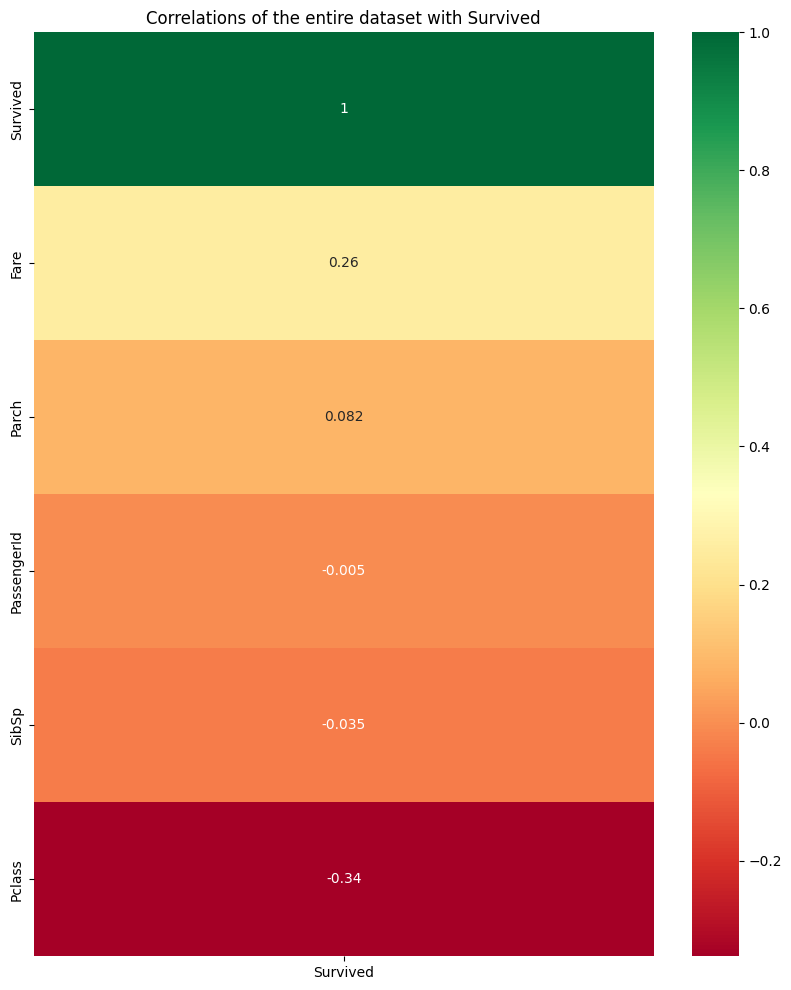

In [194]:
correlation_matrix = dataset.corr(numeric_only=True)

correlations = correlation_matrix[['Survived']].sort_values(by='Survived', ascending=False)

plt.figure(figsize=(10, 12))
sb.heatmap(correlations, annot=True, cbar=True, cmap="RdYlGn")
plt.title('Correlations of the entire dataset with Survived')
plt.show()

### Kruskal-Wallis

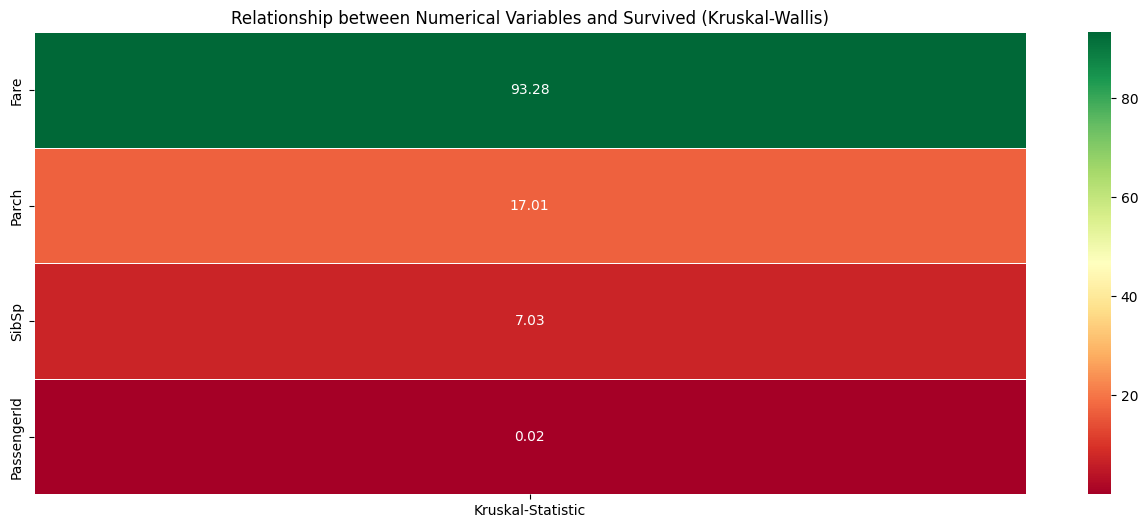

In [195]:
from scipy.stats import kruskal

numerical_columns = dataset[df_continuous.keys()]
kruskal_results = {}


for col in numerical_columns:
    groups = [dataset[dataset['Survived'] == label][col] for label in dataset['Survived'].unique()]
    stat, p_value = kruskal(*groups)
    kruskal_results[col] = stat


kruskal_results_df = pd.DataFrame.from_dict(kruskal_results, orient='index', columns=['Kruskal-Statistic'])
kruskal_results_df = kruskal_results_df.sort_values(by='Kruskal-Statistic', ascending=False)

plt.figure(figsize=(16, 6))
sb.heatmap(kruskal_results_df, annot=True, cbar=True, cmap="RdYlGn", linewidths=0.5, fmt=".2f")
plt.title('Relationship between Numerical Variables and Survived (Kruskal-Wallis)')
plt.show()

### Chi-cuadrado

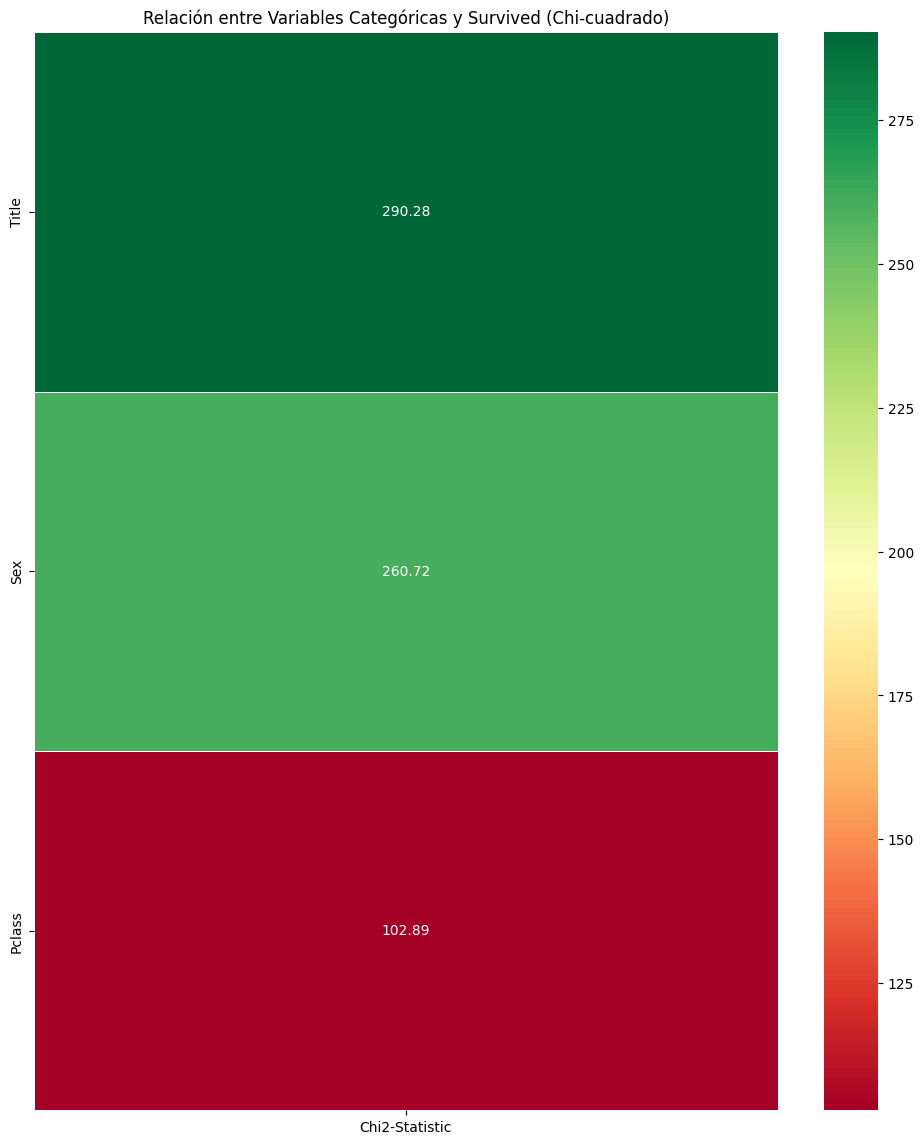

In [196]:
from scipy.stats import chi2_contingency
categorical_keys_filtered = [key for key in df_categorical.keys() if key != 'Survived']
categorical_columns = dataset[categorical_keys_filtered]

chi2_results = {}

for col in categorical_columns:
    contingency_table = pd.crosstab(dataset[col], dataset['Survived'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results[col] = chi2_stat

chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['Chi2-Statistic'])
chi2_results_df = chi2_results_df.sort_values(by='Chi2-Statistic', ascending=False)

plt.figure(figsize=(12, 14))
sb.heatmap(chi2_results_df, annot=True, cbar=True, cmap="RdYlGn", linewidths=0.5, fmt=".2f")
plt.title('Relación entre Variables Categóricas y Survived (Chi-cuadrado)')
plt.show()

### conditional distribution

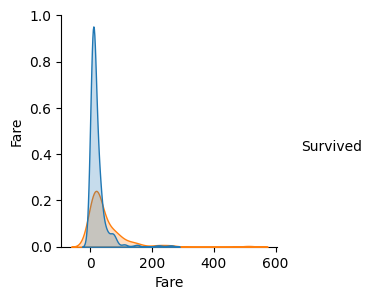

In [197]:
sb.pairplot(dataset[['Fare', 'Survived']], hue='Survived', height=3)

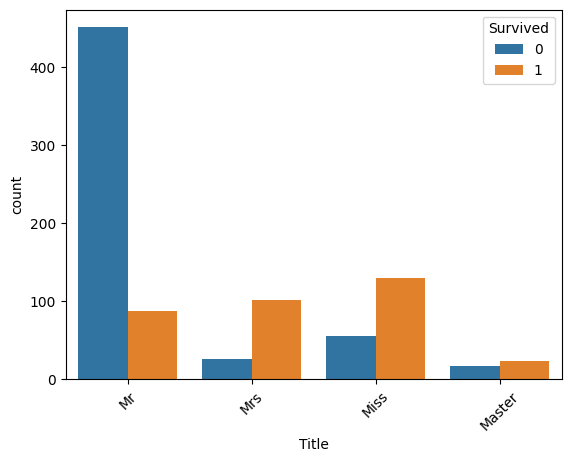

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=dataset, x='Title', hue='Survived')
plt.xticks(rotation=45)
plt.show()


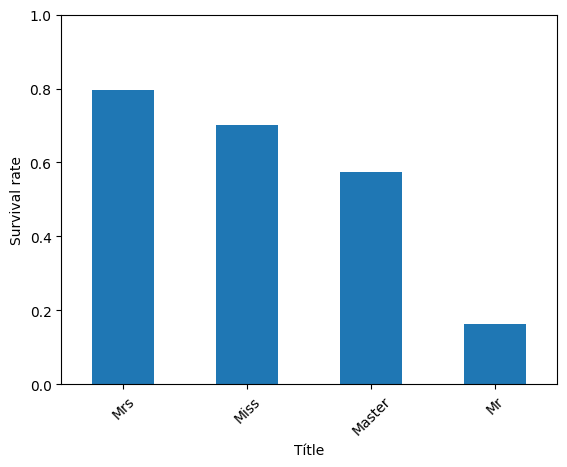

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

rate = (dataset.groupby('Title')['Survived']
        .mean()
        .sort_values(ascending=False))

rate.plot(kind='bar')
plt.ylabel('Survival rate')
plt.xlabel('Títle')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


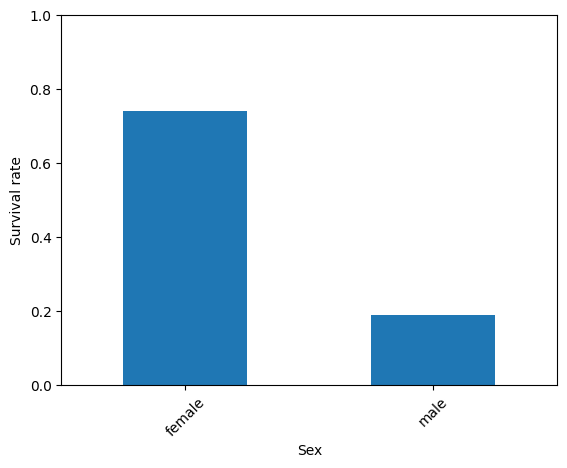

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

rate = (dataset.groupby('Sex')['Survived']
        .mean()
        .sort_values(ascending=False))

rate.plot(kind='bar')
plt.ylabel('Survival rate')
plt.xlabel('Sex')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


### Density graph

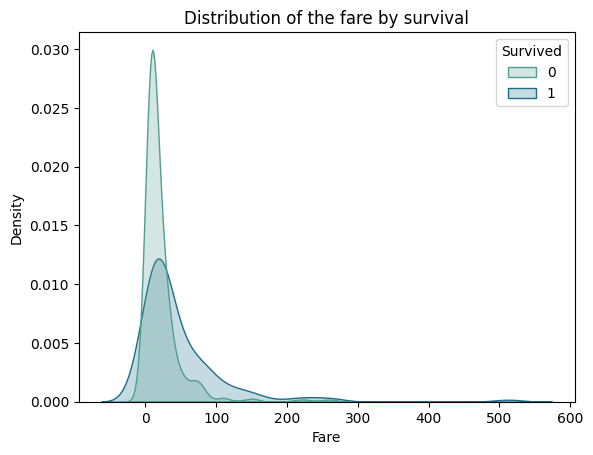

In [201]:
sb.kdeplot(data=dataset, x='Fare', hue='Survived', fill=True, common_norm=False, palette="crest")
plt.title('Distribution of the fare by survival')
plt.xlabel('Fare')
plt.ylabel('Density')
plt.show()

## balance data

In [202]:
from imblearn.under_sampling import RandomUnderSampler

X = dataset.drop("Survived", axis=1)
y = dataset["Survived"]

In [203]:
print("Class distribution")
print(dataset["Survived"].value_counts())

Class distribution
Survived
0    549
1    342
Name: count, dtype: int64


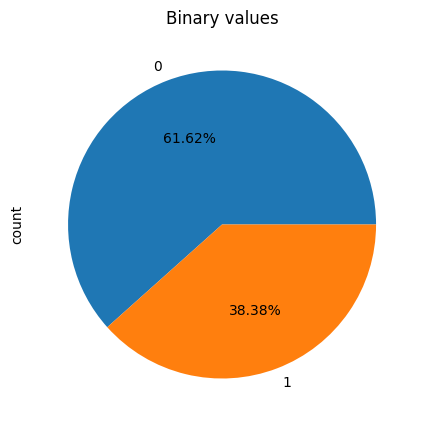

In [204]:
dataset["Survived"].value_counts().plot(kind='pie', title="Binary values", autopct='%1.2f%%', figsize=(5,5))
plt.show()

## Split data

In [205]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Onehot

In [206]:
categorical_cols = ['Pclass','Sex', 'Title']

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

X_train_enc = encoder.transform(X_train[categorical_cols])
X_test_enc  = encoder.transform(X_test[categorical_cols])

enc_cols = encoder.get_feature_names_out(categorical_cols)

X_train_enc = pd.DataFrame.sparse.from_spmatrix(X_train_enc, index=X_train.index, columns=enc_cols)
X_test_enc  = pd.DataFrame.sparse.from_spmatrix(X_test_enc,  index=X_test.index,  columns=enc_cols)

X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_enc], axis=1)
X_test_final  = pd.concat([X_test.drop(columns=categorical_cols),  X_test_enc],  axis=1)

In [207]:
X_train_final.head()

,PassengerId,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs
331,332,0,0,28.5000,1.0,0,0,0,1.0,0,0,1.0,0
733,734,0,0,13.0000,0,1.0,0,0,1.0,0,0,1.0,0
382,383,0,0,7.9250,0,0,1.0,0,1.0,0,0,1.0,0
704,705,1,0,7.8542,0,0,1.0,0,1.0,0,0,1.0,0
813,814,4,2,31.2750,0,0,1.0,1.0,0,0,1.0,0,0


## Random forest

#### Feature importance

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


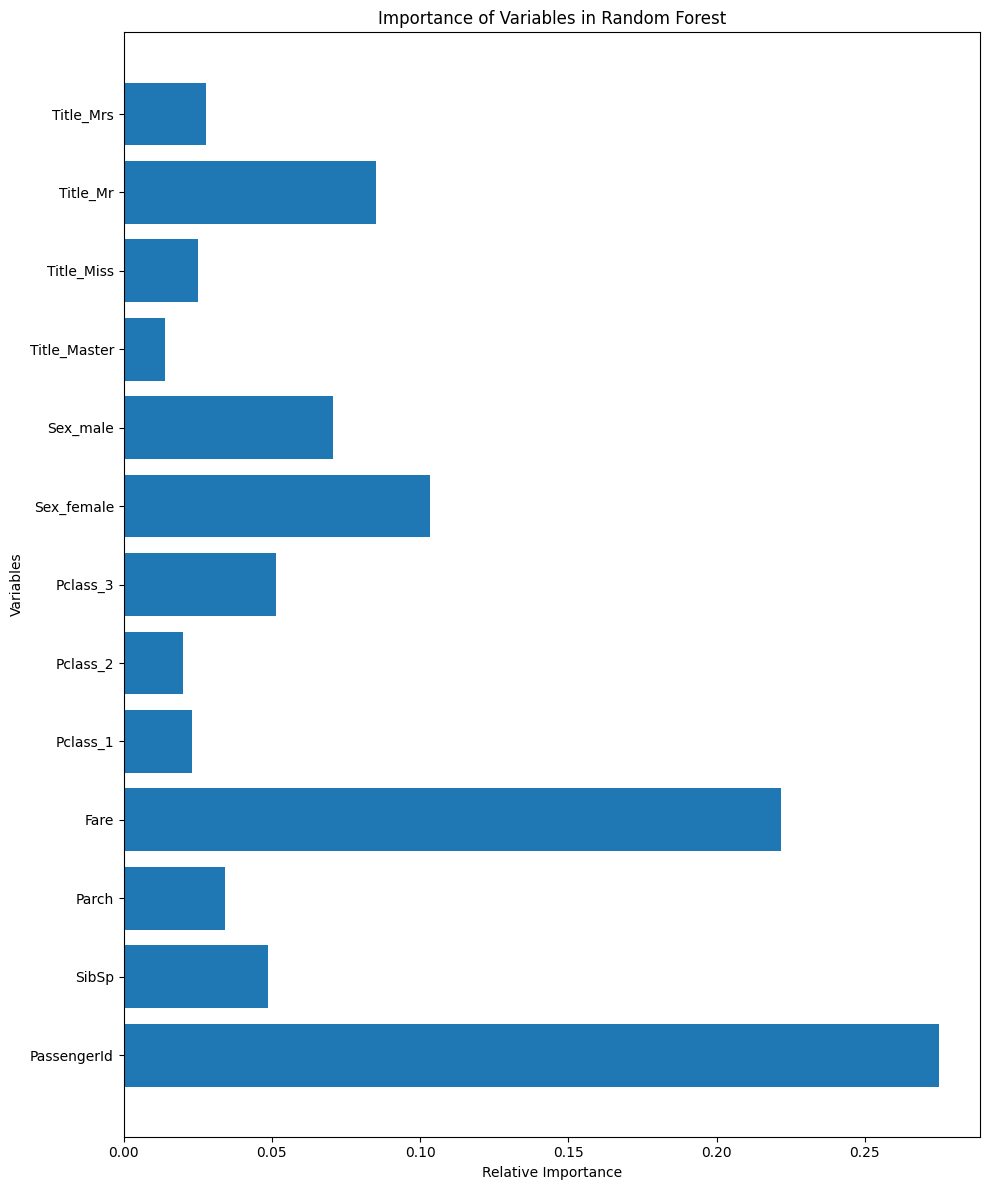

In [208]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)

importances = rf_model.feature_importances_

feature_names = X_train_final.columns

plt.figure(figsize=(10, 12))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), feature_names, fontsize=10)
plt.xlabel('Relative Importance')
plt.ylabel('Variables')
plt.title('Importance of Variables in Random Forest')
plt.tight_layout()
plt.show()

#### Training

In [259]:
from sklearn.ensemble import RandomForestClassifier

n_arboles = [5, 10, 20, 50, 100, 300, 500]
particion = 'gini'
max_depth = 10
min_samples_split = 10
min_samples_leaf = 5
max_features = "sqrt"

randomForest = [RandomForestClassifier(n_estimators = i, criterion= particion,
                                       max_depth = max_depth, min_samples_split = min_samples_split,
                                      min_samples_leaf = min_samples_leaf, max_features = max_features, class_weight="balanced") for i in n_arboles]

In [260]:
for forest in randomForest:
    forest.fit(X_train_final, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

#### Prediction

In [261]:
predictions_test = {}

for forest in randomForest:
    y_pred = forest.predict(X_test_final)
    predictions_test[forest.n_estimators] = y_pred

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea

#### Confusion matrix

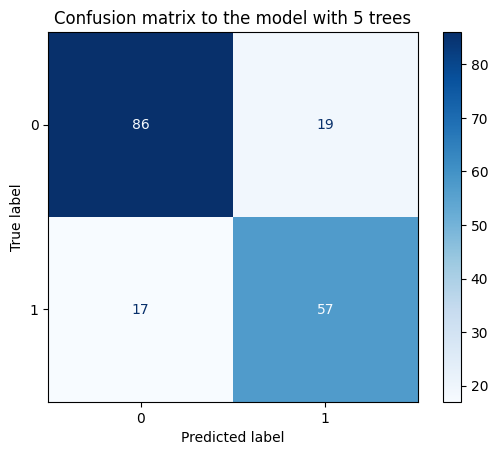

== 5 trees ==
              precision    recall  f1-score   support

           0      0.835     0.819     0.827       105
           1      0.750     0.770     0.760        74

    accuracy                          0.799       179
   macro avg      0.792     0.795     0.793       179
weighted avg      0.800     0.799     0.799       179



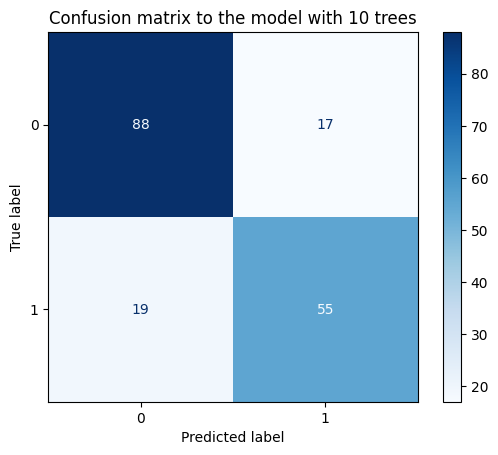

== 10 trees ==
              precision    recall  f1-score   support

           0      0.822     0.838     0.830       105
           1      0.764     0.743     0.753        74

    accuracy                          0.799       179
   macro avg      0.793     0.791     0.792       179
weighted avg      0.798     0.799     0.798       179



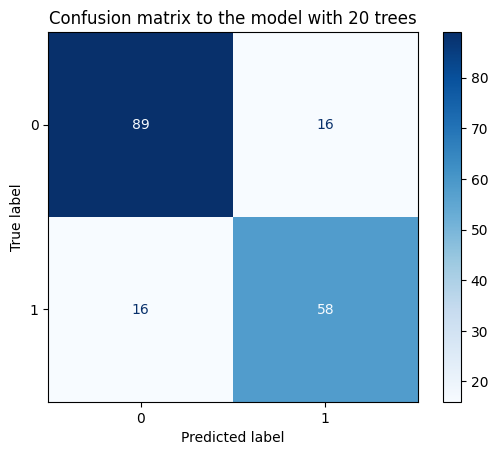

== 20 trees ==
              precision    recall  f1-score   support

           0      0.848     0.848     0.848       105
           1      0.784     0.784     0.784        74

    accuracy                          0.821       179
   macro avg      0.816     0.816     0.816       179
weighted avg      0.821     0.821     0.821       179



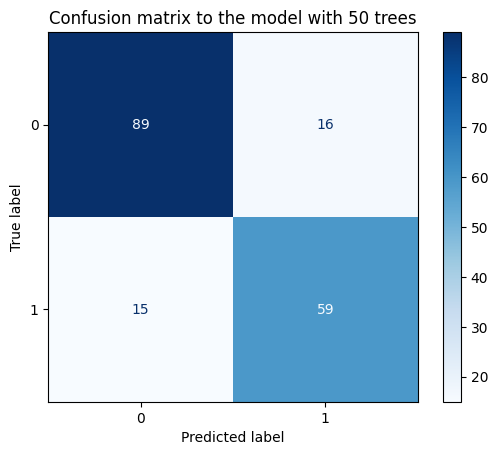

== 50 trees ==
              precision    recall  f1-score   support

           0      0.856     0.848     0.852       105
           1      0.787     0.797     0.792        74

    accuracy                          0.827       179
   macro avg      0.821     0.822     0.822       179
weighted avg      0.827     0.827     0.827       179



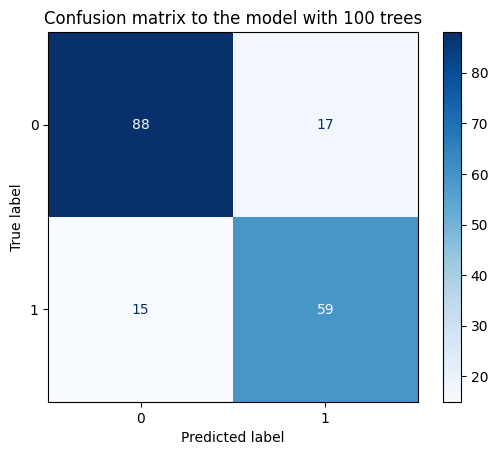

== 100 trees ==
              precision    recall  f1-score   support

           0      0.854     0.838     0.846       105
           1      0.776     0.797     0.787        74

    accuracy                          0.821       179
   macro avg      0.815     0.818     0.816       179
weighted avg      0.822     0.821     0.822       179



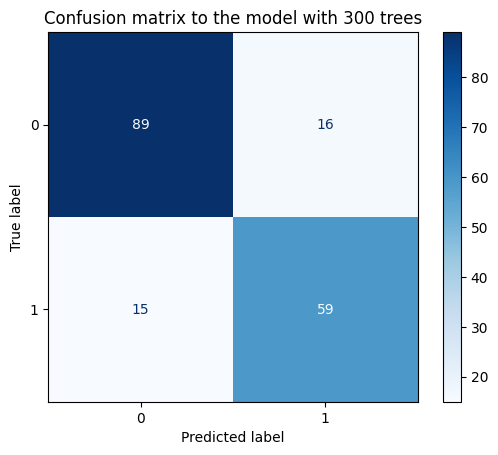

== 300 trees ==
              precision    recall  f1-score   support

           0      0.856     0.848     0.852       105
           1      0.787     0.797     0.792        74

    accuracy                          0.827       179
   macro avg      0.821     0.822     0.822       179
weighted avg      0.827     0.827     0.827       179



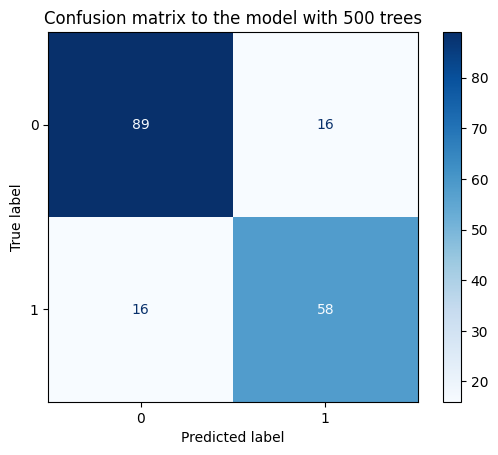

== 500 trees ==
              precision    recall  f1-score   support

           0      0.848     0.848     0.848       105
           1      0.784     0.784     0.784        74

    accuracy                          0.821       179
   macro avg      0.816     0.816     0.816       179
weighted avg      0.821     0.821     0.821       179



In [262]:
cnfusion_matrix = {}

for n_est, y_pred in sorted(predictions_test.items()):
    cm = confusion_matrix(y_test, y_pred)
    cnfusion_matrix[n_est] = cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix to the model with {n_est} trees')
    plt.show()

    print(f'== {n_est} trees ==')
    print(classification_report(y_test, y_pred, digits=3))

In [263]:
for n_est, cm in sorted(cnfusion_matrix.items()):
    print(f"\n=== Modelo con {n_est} árboles ===")
    n_classes = cm.shape[0]

    for i in range(n_classes):
        correct_predictions = cm[i, i]
        total_predictions = cm[i, :].sum()
        hit_rate = (correct_predictions / total_predictions * 100) if total_predictions > 0 else float('nan')

        # errores más comunes de la clase i (excluye la diagonal)
        row = cm[i, :].copy()
        row[i] = -1  # para no elegir la diagonal como "error"
        top_idx = row.argsort()[::-1][:min(3, n_classes-1)]
        errors = [(j, cm[i, j]) for j in top_idx if cm[i, j] > 0]

        print(f"Clase {i}:")
        print(f"  Predicciones Correctas: {correct_predictions}")
        print(f"  Total de Predicciones (verdaderos {i}): {total_predictions}")
        print(f"  Tasa de Acierto: {hit_rate:.2f}%")
        print("  Errores más comunes:")
        if errors:
            for j, cnt in errors:
                print(f"    Confundido con clase {j}: {cnt} veces")
        else:
            print("    (sin errores)")



=== Modelo con 5 árboles ===
Clase 0:
  Predicciones Correctas: 86
  Total de Predicciones (verdaderos 0): 105
  Tasa de Acierto: 81.90%
  Errores más comunes:
    Confundido con clase 1: 19 veces
Clase 1:
  Predicciones Correctas: 57
  Total de Predicciones (verdaderos 1): 74
  Tasa de Acierto: 77.03%
  Errores más comunes:
    Confundido con clase 0: 17 veces

=== Modelo con 10 árboles ===
Clase 0:
  Predicciones Correctas: 88
  Total de Predicciones (verdaderos 0): 105
  Tasa de Acierto: 83.81%
  Errores más comunes:
    Confundido con clase 1: 17 veces
Clase 1:
  Predicciones Correctas: 55
  Total de Predicciones (verdaderos 1): 74
  Tasa de Acierto: 74.32%
  Errores más comunes:
    Confundido con clase 0: 19 veces

=== Modelo con 20 árboles ===
Clase 0:
  Predicciones Correctas: 89
  Total de Predicciones (verdaderos 0): 105
  Tasa de Acierto: 84.76%
  Errores más comunes:
    Confundido con clase 1: 16 veces
Clase 1:
  Predicciones Correctas: 58
  Total de Predicciones (verdade

In [264]:
data = []

for n_est, cm in sorted(cnfusion_matrix.items()):
    n_classes = cm.shape[0]

    for i in range(n_classes):   # recorrer clases
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total * 100 if total > 0 else float("nan")

        data.append({
            "Árboles": n_est,
            "Clase": i,
            "Predicciones Correctas": correct,
            "Total de Predicciones": total,
            "Tasa de Acierto": f"{acc:.2f}%"
        })


df_report_rf = pd.DataFrame(data).set_index(["Árboles", "Clase"])

print(df_report_rf.head(10))


               Predicciones Correctas  Total de Predicciones Tasa de Acierto
Árboles Clase                                                               
5       0                          86                    105          81.90%
        1                          57                     74          77.03%
10      0                          88                    105          83.81%
        1                          55                     74          74.32%
20      0                          89                    105          84.76%
        1                          58                     74          78.38%
50      0                          89                    105          84.76%
        1                          59                     74          79.73%
100     0                          88                    105          83.81%
        1                          59                     74          79.73%


#### Accuracy

In [265]:
accuracies = []
for i, predictions in enumerate(predictions_test):
    y_pred = predictions_test[predictions]
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Model with {n_arboles[i]} trees: Precision = {accuracy:.4f}')

Model with 5 trees: Precision = 0.7989
Model with 10 trees: Precision = 0.7989
Model with 20 trees: Precision = 0.8212
Model with 50 trees: Precision = 0.8268
Model with 100 trees: Precision = 0.8212
Model with 300 trees: Precision = 0.8268
Model with 500 trees: Precision = 0.8212


#### Reporting

In [269]:
y_pred_best_model = predictions_test[50]

labels = [0, 1]
names = ["Not survived", "Survived"]

print(classification_report(y_test, y_pred_best_model,
                            labels=labels,
                            target_names=names,
                            zero_division=0))

              precision    recall  f1-score   support

Not survived       0.86      0.85      0.85       105
    Survived       0.79      0.80      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### Metrics

#### MAE

In [270]:
errors = abs(y_pred_best_model - y_test)


print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.17


### overfitting/underfitting

In [268]:
i = 0
for forest in randomForest:
    y_pred_train = forest.predict(X_train_final)
    tree = n_arboles[i]
    y_pred_test = predictions_test[tree]
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'Modelo con {forest.n_estimators} árboles: Precisión entrenamiento = {accuracy_train:.4f}')
    print(f'Modelo con {forest.n_estimators} árboles: Precisión pruebas = {accuracy_test:.4f}')
    i+=1

Modelo con 5 árboles: Precisión entrenamiento = 0.8553
Modelo con 5 árboles: Precisión pruebas = 0.7989
Modelo con 10 árboles: Precisión entrenamiento = 0.8610
Modelo con 10 árboles: Precisión pruebas = 0.7989
Modelo con 20 árboles: Precisión entrenamiento = 0.8652
Modelo con 20 árboles: Precisión pruebas = 0.8212
Modelo con 50 árboles: Precisión entrenamiento = 0.8624
Modelo con 50 árboles: Precisión pruebas = 0.8268
Modelo con 100 árboles: Precisión entrenamiento = 0.8680
Modelo con 100 árboles: Precisión pruebas = 0.8212
Modelo con 300 árboles: Precisión entrenamiento = 0.8680
Modelo con 300 árboles: Precisión pruebas = 0.8268
Modelo con 500 árboles: Precisión entrenamiento = 0.8652
Modelo con 500 árboles: Precisión pruebas = 0.8212


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklea